# Physics-Informed Neural Networks

## Allan Peter Engsig-Karup (apek@dtu.dk)
## May 7th, 2024

In [1]:
import notebook as nb
print(nb.__version__)

6.3.0


In [2]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__ 
list(imports())

['builtins', 'builtins', 'notebook', 'types']

We consider in the following the use of Physics-Informed Neural Networks(PINNs) for the construction of a surrogate model for the solution to the linear advection equation in one space dimension.
$u_{t}+cu_{x}=0 \qquad  t ∈ \mathbb{R^+}, x ∈ \mathbb{R}$ 
This problem have analytical solutions in the form $u(x,t)=f(x-ct)$, and an initial condition of the form $u(x,0)=f(x)=\sin(\pi x)$ is assumed. For $c>0$, a boundary condition is imposed on the left boundary because the information is travelling from left to right in this case
$u(0,t)=f(-ct)=\sin(-\pi ct)$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# High precision
torch.set_default_dtype(torch.float64)

# Define device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA on GPU")
# Check for MPS availability next if CUDA is not available (for macOS with Apple Silicon)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS on Apple Silicon GPU")
    torch.set_default_dtype(torch.float32) # mps does not allow for float64
# Default to CPU if neither CUDA nor MPS is available
else:
    device = torch.device("cpu")
    print("Using CPU")

# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 1)
        )

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        u = self.net(xt)
        return u

# Helper functions to calculate derivatives
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

# Physics-informed loss
def loss_fn(model, x, t, c):
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)

    u_t = grad(u, t)
    u_x = grad(u, x)

    # PDE loss
    f = u_t + c * u_x  # Ensure 'c' is defined or passed to the function

    # Boundary conditions (ensure these are correct for your problem) 
    boundary_condition = model(torch.zeros_like(x), t) - torch.sin(2*np.pi *(-1- c * t)) -torch.sin(2*np.pi *(1- c * t))
    initial_condition = model(x, torch.zeros_like(t)) - torch.sin(2*np.pi *x)

    # Compute MSE for PDE, boundary, and initial conditions
    loss_pde = torch.mean(f**2)
    loss_boundary = torch.mean(boundary_condition**2)
    loss_initial = torch.mean(initial_condition**2)

    return loss_pde + 10.0*loss_boundary + 10.0*loss_initial
    
# Training
def train(model, epochs, optimizer, x, t,c):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        l = loss_fn(model, x, t,c)
        l.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {l.item()}')

# Grid points
xmin, xmax, nx = -1, 1, 100
tmin, tmax, nt = 0, 2, 100
x = torch.linspace(xmin, xmax, nx, device=device).unsqueeze(1)
t = torch.linspace(tmin, tmax, nt, device=device).unsqueeze(1)
x_mesh, t_mesh = torch.meshgrid(x.flatten(), t.flatten())
x_mesh, t_mesh = x_mesh.flatten().unsqueeze(1), t_mesh.flatten().unsqueeze(1)

# Constants
c = 0.5

# Initialize model, optimizer
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train(model, 1000, optimizer, x_mesh, t_mesh,c)


Using CPU


c:\Users\maria\.conda\envs\DataAlgo\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0: Loss = 10.003397056098315
Epoch 50: Loss = 1.6148269982715995
Epoch 100: Loss = 0.4601925562211442
Epoch 150: Loss = 0.19991501876304574
Epoch 200: Loss = 0.00678264343851096
Epoch 250: Loss = 0.00256613424514446
Epoch 300: Loss = 0.006915982001014039
Epoch 350: Loss = 0.0016318991820712886
Epoch 400: Loss = 0.0017508344769557914
Epoch 450: Loss = 0.0029731297887669334
Epoch 500: Loss = 0.0008072975169557139
Epoch 550: Loss = 0.008509982967125376
Epoch 600: Loss = 0.0010074023157829904
Epoch 650: Loss = 0.008445513820941015
Epoch 700: Loss = 0.0007568895384277345
Epoch 750: Loss = 0.010997258427725967
Epoch 800: Loss = 0.011338787853660225
Epoch 850: Loss = 0.00056687868307543
Epoch 900: Loss = 0.028028151207539473
Epoch 950: Loss = 0.02524285163382913


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming 'model' and 'device' are already defined and the model is trained.

# Generate predictions from the trained model
model.eval()  # Set the model to evaluation mode 
with torch.no_grad():
    u_pred = model(x_mesh, t_mesh).cpu().numpy()

# Exact solution (update this according to your problem's exact solution)
u_exact = np.sin( 2*np.pi * (x_mesh.cpu().detach().numpy() - c*t_mesh.cpu().detach().numpy()))
                 
# Compute L2 errors
l2_err = np.sum((u_exact - u_pred)**2)
l2_err_t0 = np.sum((u_exact[0, :] - u_pred[0, :])**2)
l2_err_tmax = np.sum((u_exact[-1, :] - u_pred[-1, :])**2)

# Output error information
print(f'L2 err, all timesteps: {l2_err}')
print(f'Avg-L2 err, all timesteps: {l2_err/u_pred.size}')
print(f'L2 err, t=0: {l2_err_t0}')
print(f'L2 err, t={tmax}: {l2_err_tmax}')


L2 err, all timesteps: 1817.6816163038504
Avg-L2 err, all timesteps: 0.18176816163038503
L2 err, t=0: 1.085774679534034e-05
L2 err, t=2: 0.00012371427001436382


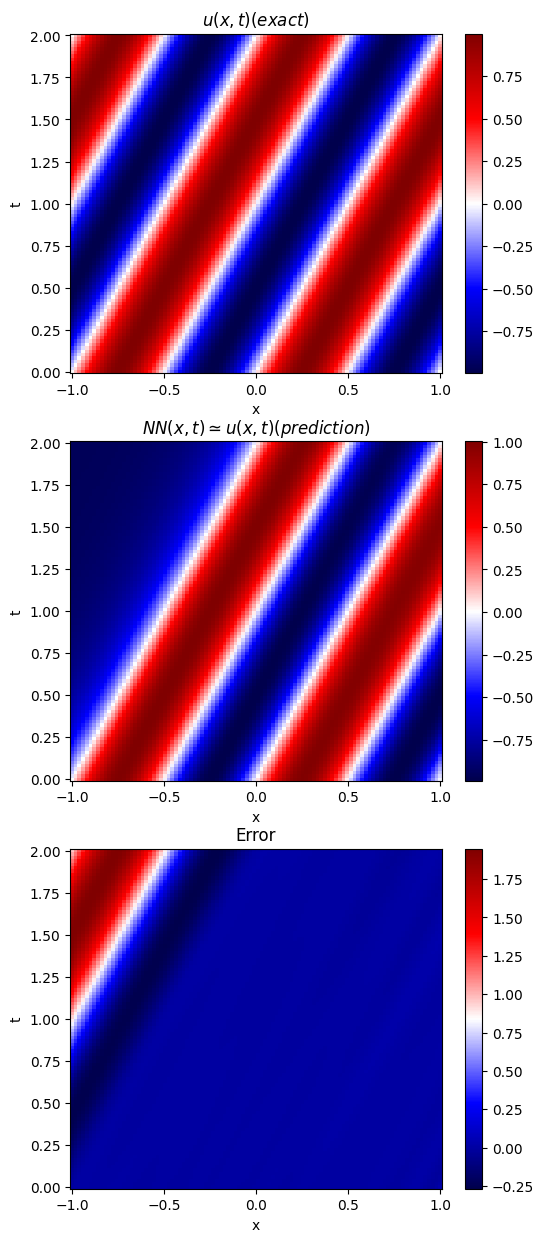

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your x_mesh and t_mesh are defined correctly in the tensor form.
x = torch.linspace(xmin, xmax, nx, device=device).cpu().numpy()
t = torch.linspace(tmin, tmax, nt, device=device).cpu().numpy()

# Since these are grid centers, calculate the step size and expand the grid to cover edges.
x_step = (x[1] - x[0])
t_step = (t[1] - t[0])

# Create new arrays that represent the edges, not the centers
x_edges = np.append(x, x[-1] + x_step) - x_step/2
t_edges = np.append(t, t[-1] + t_step) - t_step/2

# Use these arrays for pcolormesh
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 15))

# Exact solution
ax = axes[0]
cc = ax.pcolormesh(x_edges, t_edges, u_exact.reshape((nt, nx)).T, cmap='seismic', shading='auto')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('$u(x,t) (exact)$')
fig.colorbar(cc, ax=ax)

# Predicted solution
ax = axes[1]
cc = ax.pcolormesh(x_edges, t_edges, u_pred.reshape((nt, nx)).T, cmap='seismic', shading='auto')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('$NN(x,t)\simeq u(x,t) (prediction)$')
fig.colorbar(cc, ax=ax)

# Errors
ax = axes[2]
cc = ax.pcolormesh(x_edges, t_edges, (u_exact.reshape((nt, nx)) - u_pred.reshape((nt, nx))).T, cmap='seismic', shading='auto')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Error')
fig.colorbar(cc, ax=ax)